In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [5]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [11]:
from inference.inference_utils import choose_model , plot_topk_accuracy
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK


In [7]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional2", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)



loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_2/checkpoints/epoch=91-step=20792.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [8]:
datamodule.setup("predict")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.predict_dataloader()

In [9]:
max_radius = fp_loader.max_radius
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")
rankingset_data = rankingset_data.to(model.device)


/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [10]:
from rdkit.Chem import rdFingerprintGenerator

def gen_mfp(smiles):
    MFP_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    mol = Chem.MolFromSmiles(smiles)
    fp = MFP_generator.GetFingerprint(mol)
    return torch.tensor(fp).float()

def cos_sim_of_smiles(smiles1, smiles2):
    try:
        fp1 = gen_mfp(smiles1)
        fp2 = gen_mfp(smiles2)
        cos_sim = torch.nn.functional.cosine_similarity(fp1, fp2, dim=0)
        return cos_sim.item()
    except Exception as e:
        return 0

from torch.nn.functional import cosine_similarity
import tqdm

In [13]:
# Order: [loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR]

old_loader_idx_to_name_mapping = {
    0: "All Inputs",
    1: "HSQC and H NMR",
    2: "HSQC and C NMR",
    3: "HSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC (Non-Multiplicity-Edited)",
}


loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC only",
    8: "Standard HSQC, H NMR, and C NMR",
    9: "Standard HSQC and H NMR",
    10: "Standard HSQC and C NMR",
    
    
}

old_name_to_loader_idx_mapping = {v: k for k, v in old_loader_idx_to_name_mapping.items()}

In [ ]:
from collections import defaultdict

## with MW
mean_rank_records = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=25)
        idx_retrieval=0
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            if cos_sim_of_smiles(retrieval_smile, ground_smiles[0]) >= 0.8:
                break
            idx_retrieval += 1
        mean_rank_records[loader_idx_to_name_mapping[i]].append(idx_retrieval)

  0%|          | 19/4056 [00:00<02:11, 30.59it/s]

 16%|█▋        | 660/4056 [01:49<09:11,  6.15it/s]

In [ ]:
from collections import defaultdict

## without MW
mean_rank_records_no_mw = defaultdict(list)
for i in range(11):
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in enumerate(tqdm.tqdm(test_dataloaders[loader_idx])):
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            inputs, extra_info = batch
            (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
        
            inputs = inputs.to(model.device)
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
            
            # remove mw
            inputs = inputs[:, :-1]
            # remove mw
            NMR_type_indicator = NMR_type_indicator[:-1]
            
            pred = model(inputs, NMR_type_indicator)
            pred=torch.sigmoid(pred) # sigmoid
            topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=25)
        idx_retrieval=0
        for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
                
            if cos_sim_of_smiles(retrieval_smile, ground_smiles[0]) >= 0.8:
                break
            idx_retrieval += 1
        mean_rank_records_no_mw[loader_idx_to_name_mapping[i]].append(idx_retrieval)
        
        

  0%|          | 0/4056 [00:00<?, ?it/s]

100%|██████████| 4056/4056 [02:24<00:00, 28.01it/s]


In [ ]:
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_annotation_with_mw_2.pkl", 'wb') as file:
    pickle.dump(mean_rank_records, file)
with open(save_dir + "topk_annotation_without_mw_2.pkl", 'wb') as file:
    pickle.dump(mean_rank_records_no_mw, file)
   

In [ ]:
# # cobining DeepSAT result into mean_rank_records_no_MW
# # import pickle
# import tqdm
# # from collections import defaultdict
# # mean_rank_records_no_mw = defaultdict(list)
# shared_testset_pkl = "shared_testset_path_for_deepsat_hsqc_available" 
# with open(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/{shared_testset_pkl}.pkl", "rb") as f:
#     shared_testset_path = pickle.load(f)
    
    
# deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set.pkl"
# with open(deepsat_infer_results_save_path, "rb") as f:
#     deepsat_infer_results = pickle.load(f)
    
# mean_rank_records_no_mw.update({"DeepSAT -- eHSQC": []})  
# for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
#     result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
#     for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
#         # if ( ground_smiles == filtered_smiles):
        
#         if cos_sim_of_smiles(filtered_smiles, ground_smiles) >= 0.8:
#             mean_rank_records_no_mw["DeepSAT -- eHSQC"].append(i)
#             break
#     else:
#         mean_rank_records_no_mw["DeepSAT -- eHSQC"].append(50)
        
        
        
# deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set_standard_HSQC.pkl"
# with open(deepsat_infer_results_save_path, "rb") as f:
#     deepsat_infer_results = pickle.load(f)
    
# mean_rank_records_no_mw.update({"DeepSAT -- Standard HSQC": []})  
# for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
#     result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
#     for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
#         if cos_sim_of_smiles(filtered_smiles, ground_smiles) >= 0.8:
#             mean_rank_records_no_mw["DeepSAT -- Standard HSQC"].append(i)
#             break
#     else:
#         mean_rank_records_no_mw["DeepSAT -- Standard HSQC"].append(50)

100%|██████████| 341/341 [00:00<00:00, 11468.94it/s]


In [1]:
# plotting anootation stuff
import pickle

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_annotation_with_mw.pkl", 'rb') as file:
    mean_rank_records = pickle.load(file)
with open(save_dir + "topk_annotation_without_mw.pkl", 'rb') as file:
    mean_rank_records_without_mw = pickle.load(file)
    
mean_rank_records_without_mw.pop("DeepSAT -- eHSQC")
mean_rank_records_without_mw.pop("DeepSAT -- Standard HSQC")


with open(save_dir + "topk_annotation_with_mw_2.pkl", 'rb') as file:
    mean_rank_records_2 = pickle.load(file)
with open(save_dir + "topk_annotation_without_mw_2.pkl", 'rb') as file:
    mean_rank_records_without_mw_2 = pickle.load(file)
    
with open(save_dir + "topk_annotation_with_mw_3.pkl", 'rb') as file:
    mean_rank_records_3 = pickle.load(file)
with open(save_dir + "topk_annotation_without_mw_3.pkl", 'rb') as file:
    mean_rank_records_without_mw_3 = pickle.load(file)
    
    

In [2]:


ylabel = "% of correct annotation(containing a compound with >0.8 similarity to truth compound)"


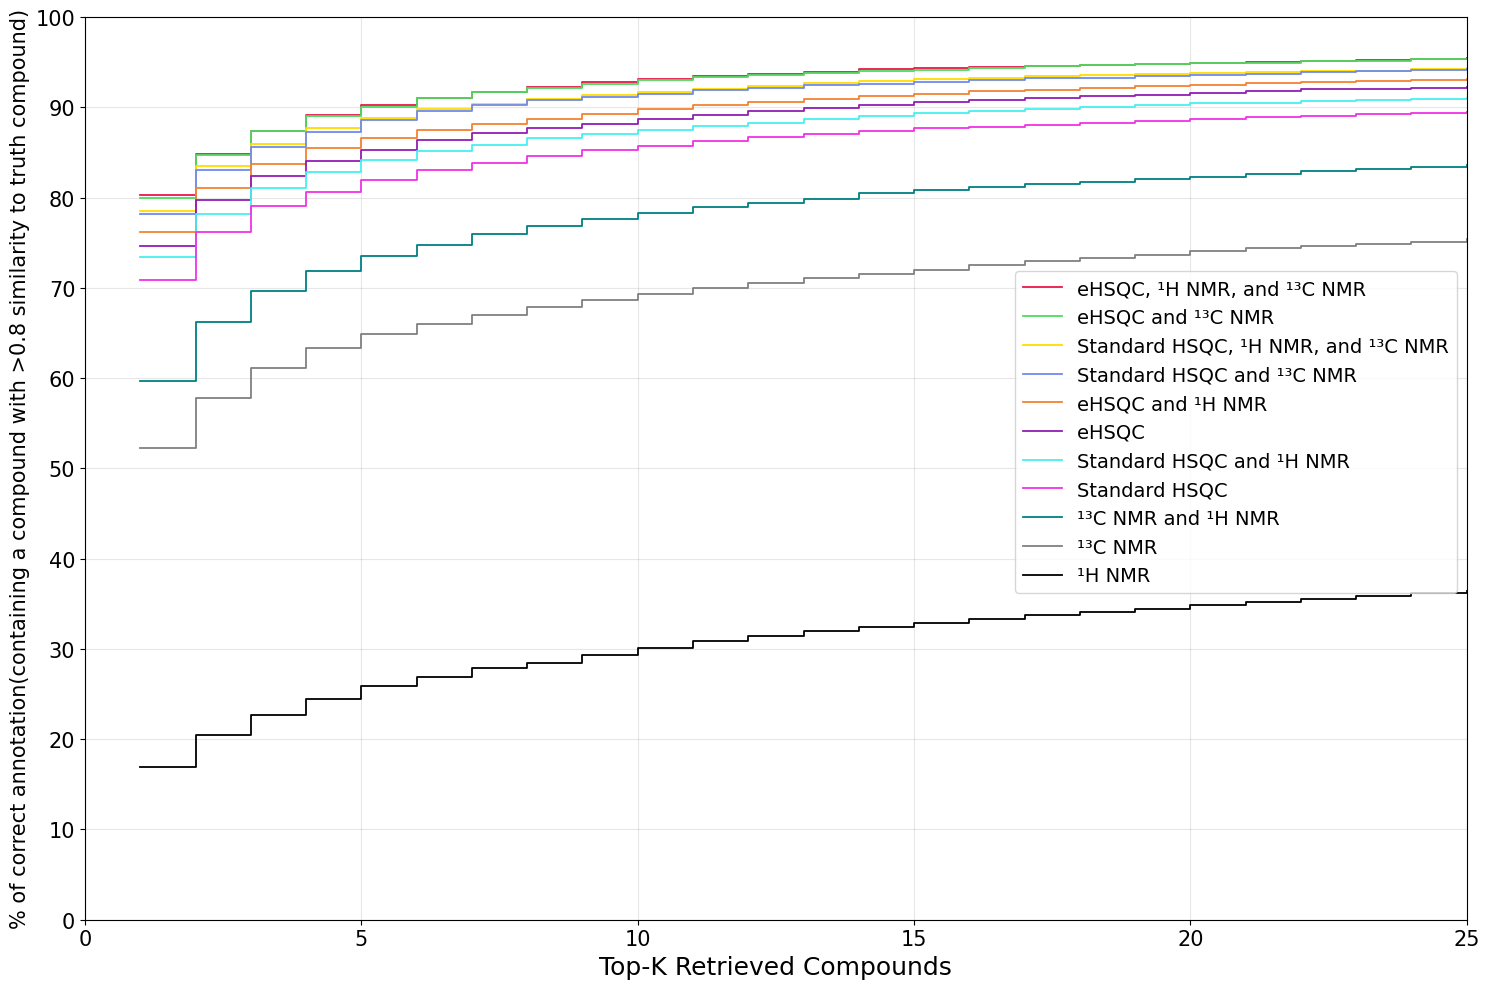

In [3]:

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
from inference.inference_utils import choose_model , plot_topk_accuracy
data_list = [mean_rank_records, mean_rank_records_2,  mean_rank_records_3]
plot_topk_accuracy(data_list, title="", 
                   max_k=25,
                   bbox_to_anchor=(1,0.54),
                   ylabel = ylabel) #Structure annotation (using molecular weight)

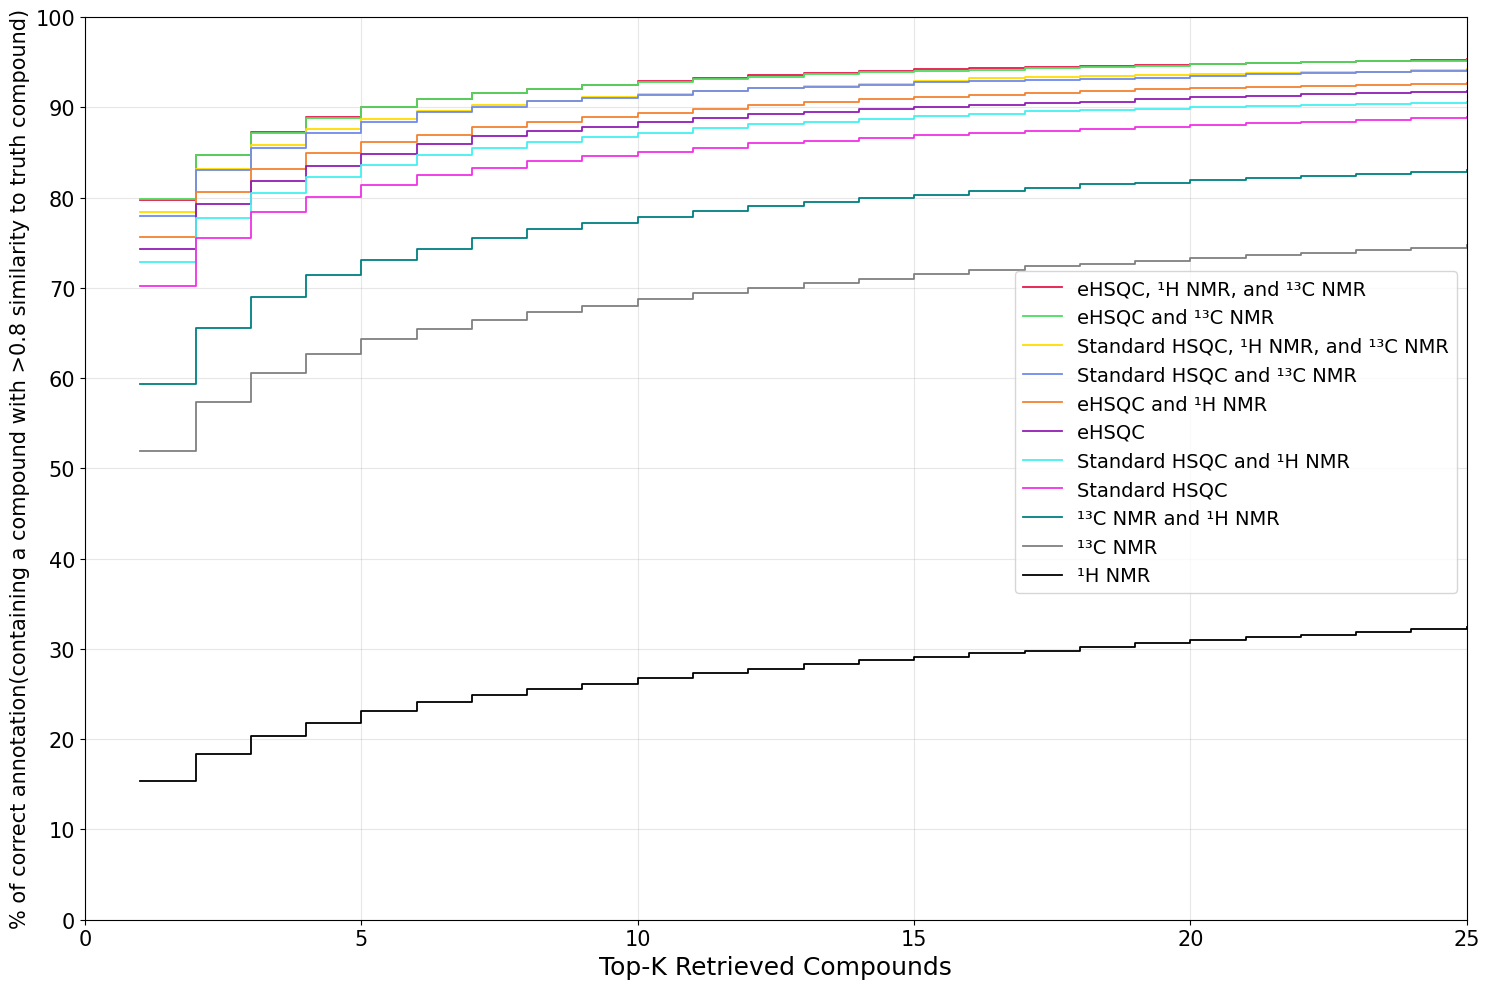

In [4]:
data_list = [mean_rank_records_without_mw, mean_rank_records_without_mw_2,  mean_rank_records_without_mw_3]

plot_topk_accuracy(data_list, title="", 
                   max_k=25,
                   bbox_to_anchor=(1,0.54),
                   ylabel = ylabel) #Structure Dereplication (not using molecular weight)



In [5]:
# import pickle

# save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

# with open(save_dir + "topk_annotation_without_mw.pkl", 'rb') as file:
#     mean_rank_records_no_mw = pickle.load(file)
   